In [1]:
import keras
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.applications.densenet import DenseNet201
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

Using TensorFlow backend.


In [2]:
labels = ['PNEUMONIA', 'NORMAL','COVID','TUBERCULOSIS']
img_size = 224

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir,label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                new_img = cv2.imread(os.path.join(path,img))
                resized_img = cv2.resize(new_img,(img_size,img_size))
                data.append([resized_img,class_num])
            except:
                continue
    return np.array(data)      
    

In [3]:
train = get_data('C:/Final Year Project/X-Ray Images/train')
test = get_data('C:/Final Year Project/X-Ray Images/test')


In [4]:
X_train = []
y_train = []

X_test = []
y_test = []

for img,label in train:
    X_train.append(img)
    y_train.append(label)
    
for img,label in test:
    X_test.append(img)
    y_test.append(label)

In [5]:
X_train[0].shape

(224, 224, 3)

In [7]:
# Import the DenseNet201 library as shown below and add preprocessing layer to the front of DenseNet
# Here we will be using imagenet weights

densenet = DenseNet201(input_shape=[224,224]+ [3], weights='imagenet', include_top=False)

In [8]:
# don't train existing weights
for layer in densenet.layers:
    layer.trainable = False

In [9]:
# our layers - you can add more if you want
x = Flatten()(densenet.output)

In [11]:
prediction = Dense(4, activation='softmax')(x)

# create a model object
model = Model(inputs=densenet.input, outputs=prediction)

In [12]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [13]:
from glob import glob

folders = glob('C:/Final Year Project/X-Ray Images/train/*')
len(folders)

4

In [14]:

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [15]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [16]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('C:/Final Year Project/X-Ray Images/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 10993 images belonging to 4 classes.


In [17]:
test_set = test_datagen.flow_from_directory('C:/Final Year Project/X-Ray Images/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 1433 images belonging to 4 classes.


In [18]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
344/344 [==============================] - 1773s 5s/step - loss: 0.7969 - accuracy: 0.9072 - val_loss: 1.0932 - val_accuracy: 0.8890
Epoch 2/5
344/344 [==============================] - 1724s 5s/step - loss: 0.6725 - accuracy: 0.9421 - val_loss: 2.2904 - val_accuracy: 0.8479
Epoch 3/5
344/344 [==============================] - 1742s 5s/step - loss: 0.5998 - accuracy: 0.9526 - val_loss: 1.7332 - val_accuracy: 0.8953
Epoch 4/5
344/344 [==============================] - 1718s 5s/step - loss: 0.5624 - accuracy: 0.9572 - val_loss: 0.9455 - val_accuracy: 0.9379
Epoch 5/5
344/344 [==============================] - 1712s 5s/step - loss: 0.4659 - accuracy: 0.9630 - val_loss: 1.4579 - val_accuracy: 0.9156


In [19]:
model.evaluate(test_set)

45/45 [==============================] - 207s 5s/step - loss: 1.4579 - accuracy: 0.9156


[1.4578866958618164, 0.9155617356300354]

In [35]:
model.save('DenseNet201_Model.h5')

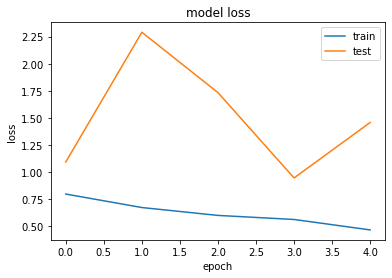

In [20]:
# plotting training set and validation test 
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

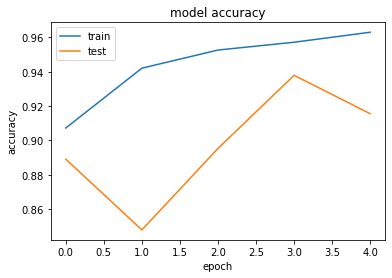

In [21]:
# plotting training set and validation test 
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix

predictions = model.predict_classes(X_test)
predictions = predictions.reshape(1,-1)[0]

print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)','Covid (Class 2)','Tuberculosis (Class 3)']))

AttributeError: 'Functional' object has no attribute 'predict_classes'

In [32]:
prediction = model.predict(test_set)